### 1. Reading in James' simulation data using Pandas

In [1]:
import pandas as pd

file_path = 'dtag/grid/4_agents/4/velocity_metrics.csv'
file_path2 = 'dtag/grid/4_agents/4/idleness.csv'
file_path3 = 'dtag/grid/4_agents/4/vulnerabilities.csv'
file_path4 = 'dtag/grid/4_agents/4/distance_metrics.csv'

df_vel = pd.read_csv(file_path, sep=';', header=None)
df_idle = pd.read_csv(file_path2, sep=';',header=None)
df_vuln = pd.read_csv(file_path3, sep=';',header=None)
df_dist = pd.read_csv(file_path4, sep=';',header=None)

### 2. Cleaning and reshaping data

In [2]:
import numpy as np

N = len(df_vel.T)-1 # number of nodes in the enviroment

# remove timestep column
vel_data = df_vel.iloc[:, 1:N+1]
idle_data = df_idle.iloc[:, 1:N+1].copy() # use copy to avoid modifcation warning
idle_data[idle_data < 0] = np.nan # set negative idle values to NaN for later removal
vuln_data = df_vuln.iloc[:, 1:N+1]
dist_data = df_dist.iloc[:, 1:N+1]

# combine datasets 
df = pd.concat([vel_data,idle_data,dist_data,vuln_data],axis=1)
df = df.replace([np.inf, -np.inf], np.nan) # set all inf values to NaN for later removal

# Drop rows with NaN values
df = df.dropna()

# attack length threshold to determine attack success and update to binary classification:
threshold = 50
for col in range(N*3,N*4):
    df.iloc[:, col] = (df.iloc[:, col] >= threshold).astype(int)

# convert data to array
dataset = df.to_numpy()

# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
trainX, trainY, testX, testY = dataset[0:train_size,0:-N], dataset[0:train_size,N*3:N*4],dataset[train_size:len(dataset),0:-N], dataset[train_size:len(dataset),N*3:N*4] 
#split is appropriate as it trains on the first set of timestep values

# reshape data to appropriate format as (timestep, number of nodes, number of features)
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[-1]//3,3))
testX = np.reshape(testX, (testX.shape[0],testX.shape[-1]//3,3))
trainY.shape

(14869, 25)

### 3. Compile and fit model

In [3]:
import tensorflow as tf
from Intruder_functionality import machine_learning as ml
import random



# Define the window size and threshold
window_size = 10
f1_threshold = 1  # Example threshold
f2_threshold = 1
f3_thresholds = np.arange(0,1,0.05)

data_shape = (window_size,trainX.shape[1], trainX.shape[-1])

model = ml.ML_Intruder(data_shape)

# Compile the model
model.compile()

list_of_attacked_nodes = []
attack_outcomes = []
timestep = []

# min_waittime = 120
ending_timestep = 2000

predictions = np.full((ending_timestep, 25),np.nan)
probabilities = np.full((ending_timestep, 1),np.nan)

for i in range(10):

    temp_time = []
    temp_outcome = []
    temp_node = []

    for f3_threshold in f3_thresholds:
        # Training loop
        for i in range(window_size, ending_timestep):

            # print(i) # for initial visualisation of training progression

            # Get the most recent window of data
            window_data = trainX[i-window_size:i,:,:]
            window_data = window_data[np.newaxis, ...]  # Add batch dimension

            # # Get the corresponding label
            label = trainY[i,:]
            label = label[np.newaxis, ...]  # Add batch dimension

            # Set replay buffer as all sequential data so far
            replay_buffer = trainX[0:i,:,:]
            replay_buffer_label = trainY[0:i,:]

            # Sample a batch from the replay buffer
            batch_size = min(len(replay_buffer), 32)  # Example batch size=32

            # generate random batch indices
            starting_index = np.random.randint(0, len(replay_buffer) - (window_size-1),size=batch_size)

            # Generate the indices for the adjacent window
            indices = [np.arange(idx, idx + window_size) for idx in starting_index]

            # Extract the batch samples and labels using the sampled indices
            replay_batch = replay_buffer[indices]
            replay_batch_labels = replay_buffer_label[[i+(window_size-1) for i in starting_index]]

            # Convert the batch to arrays
            replay_batch_array = np.array(replay_batch)
            replay_batch_labels_array = np.array(replay_batch_labels)

            # Train on the replay batch
            model.train_on_batch(replay_batch_array, replay_batch_labels_array)

            # Predict attack
            prediction = model.predict(window_data)

            # Replay buffer for model predictions
            predictions[[i+(window_size-1) for i in starting_index]] = prediction
            replay_buffer_predictions = predictions[0:i,:]

            
            probability_exceed_threshold = (1 - np.sum(replay_buffer_predictions.flatten() >= f2_threshold) / np.sum(replay_buffer_predictions.flatten() != np.nan))*np.square(i/ending_timestep)
            prob = (1 - np.sum(replay_buffer_predictions.flatten() >= f2_threshold) / np.sum(replay_buffer_predictions.flatten() != np.nan))

            probabilities[i] = probability_exceed_threshold

            # print(f"Probability of exceeding {threshold} in the remaining time: {probability_exceed_threshold}")

            # f3 function
            f3 = probability_exceed_threshold*prediction.max()


            # Check the prediction against the threshold
            if (f3 >= f3_threshold)&(prediction.max()>=f1_threshold):
                max_index = prediction.argmax()
                print(f"Threshold reached with prediction: {prediction.max()} at timestep: {i}")
                print(f"Attack succesful = {label[:,max_index]==1} | at timestep: {i}")
                time_of_attack = i
                node_attacked = max_index + 1
                attack_outcome = label[:,max_index]

                break

        temp_time.append(time_of_attack)
        temp_node.append(node_attacked)
        temp_outcome.append(attack_outcome)
        
    timestep.append(time_of_attack)
    list_of_attacked_nodes.append(node_attacked)
    attack_outcomes.append(attack_outcome)









2024-02-02 15:39:34.045527: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 102ms/step
Threshold reached with prediction: 1.0 at timestep: 10
Attack succesful = [ True] | at timestep: 10
1/1 [==============================] - 0s 22ms/step
Threshold reached with prediction: 1.0 at timestep: 480
Attack succesful = [ True] | at timestep: 480
1/1 [==============================] - 0s 24ms/step


In [ ]:
list_of_attacked_nodes = np.array(list_of_attacked_nodes)
attack_outcomes = np.array(attack_outcomes)
timestep = np.array(timestep)

# Save arrays to text file
np.savetxt('1_list_of_attacked_nodes.txt', list_of_attacked_nodes, fmt='%d')
np.savetxt('1_attack_outcomes.txt', attack_outcomes, fmt='%d')
np.savetxt('1_timestep.txt', timestep, fmt='%d')

### 4. Overall Performance Review 

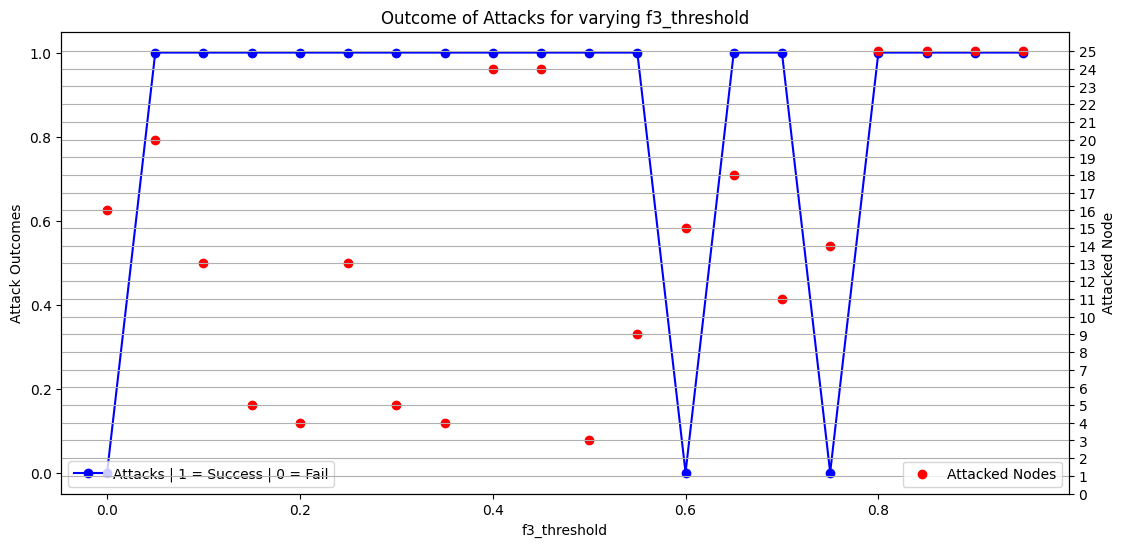

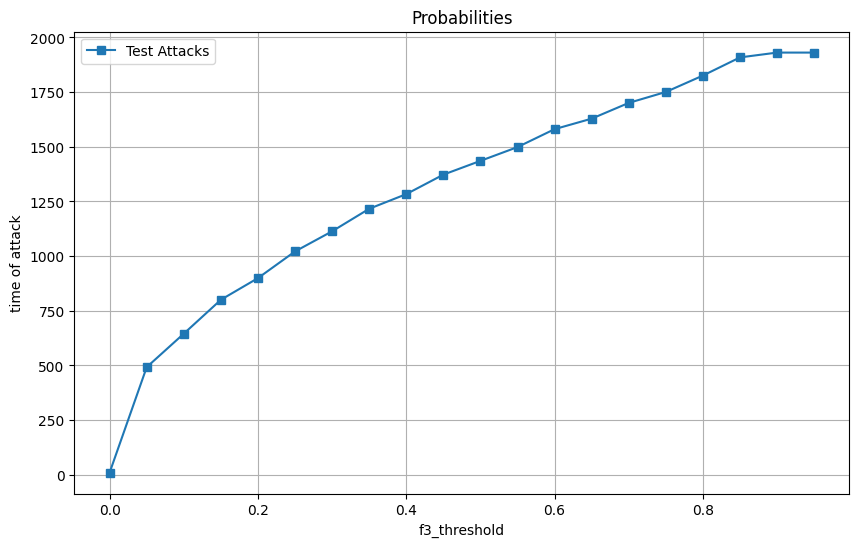

In [ ]:

import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(13, 6))

# Plot the first data on the left y-axis
# ax1.plot(f3_thresholds, attack_outcomes, label='Attacks | 1 = Success | 0 = Fail', marker='o', color='blue')
# ax1.set_ylabel('Attack Outcomes')

# Create bar graph
bar_width = 0.35  # Adjust as needed

for i in range(np.shape(timestep)[0]):

    success_counts = np.sum(attack_outcomes==1)
    failure_counts = np.sum(attack_outcomes!=1)

    bar1 = ax1.bar(f3_thresholds - bar_width/2, success_counts, bar_width, label='Success (1)')
    bar2 = ax1.bar(f3_thresholds + bar_width/2, failure_counts, bar_width, label='Failure (0)')


# # Create a twin axis on the right
# ax2 = ax1.twinx()

# # Plot the second data on the right y-axis
# ax2.scatter(f3_thresholds, list_of_attacked_nodes, label='Attacked Nodes', marker='o', color='red')
# ax2.set_ylabel('Attacked Node')

# ax2.set_yticks(np.arange(0, N+1, 1))

# Set titles, labels, and legends
ax1.set_title('Outcome of Attacks for varying f3_threshold')
ax1.set_xlabel('f3_threshold')
ax1.legend(loc='lower left')
# ax2.legend(loc='lower right')

# Display the grid
# ax2.grid(True)

# Save the plot if needed
plt.savefig("01_f3_threshold_varying_attack_outcomes.png")

# Show the plot

plt.figure(figsize=(10, 6))

plt.scatter(f3_thresholds, timestep, label='Test Attacks', marker='s')

plt.title('Time of attack for varying f3_threshold')
plt.xlabel('f3_threshold')
plt.ylabel('time of attack')
plt.legend()
plt.grid(True)
plt.savefig("01_f3_threshold_varying_times.png")


# plt.show()


In [ ]:
import numpy as np


unique_values, counts = np.unique(attack_outcomes, return_counts=True)

# Print the unique values and their counts
for value, count in zip(unique_values, counts):
    print("Value:", value, "Count:", count)

Value: 0.0 Count: 3
Value: 1.0 Count: 17
